### Card Minimum Wage

['chain', 'location', 'wageBefore', 'wageAfter', 'fullBefore', 'fullAfter', 'partBefore', 'partAfter']
['PA' 'centralNJ' 'northNJ' 'shoreNJ' 'southNJ']
['PA' 'NJ']


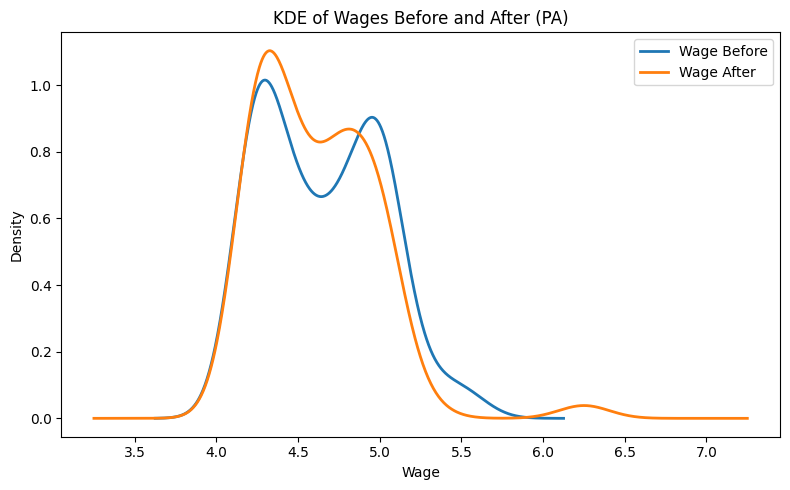

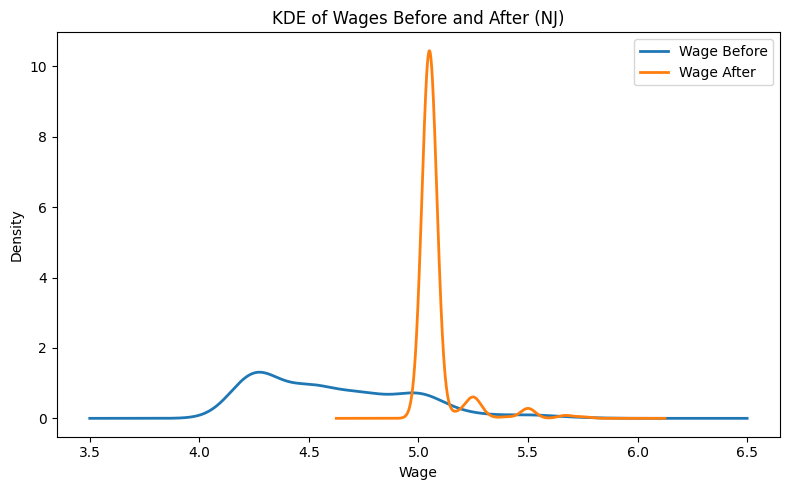

location   emp  period
0           0  40.0       0
1           0  32.0       0
2           0  85.0       0
3           0  27.0       0
4           0  10.0       0
..        ...   ...     ...
711         1  22.5       1
712         1  15.0       1
713         1  30.0       1
714         1  35.0       1
715         1  34.0       1

[716 rows x 3 columns]

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'data/minwage.csv'
data = pd.read_csv(file_path)
print(data.columns.tolist())

location_wage_data = data.groupby('location')[['wageBefore', 'wageAfter']].mean()
data['location'] = data['location'].replace(r'^NJ.*', 'NJ', regex=True)
location_wage_combined = data.groupby('location')[['wageBefore', 'wageAfter']].mean()

unique_locations = data['location'].unique()
print(unique_locations)

data['location'] = data['location'].replace(['centralNJ', 'northNJ', 'shoreNJ', 'southNJ'], 'NJ')
combined_locations = data['location'].unique()
print(combined_locations)

for loc in data['location'].unique():
    subset = data[data['location'] == loc]
    plt.figure(figsize=(8, 5))
    subset['wageBefore'].plot(kind='kde', label='Wage Before', linewidth=2)
    subset['wageAfter'].plot(kind='kde', label='Wage After', linewidth=2)
    plt.title(f'KDE of Wages Before and After ({loc})')
    plt.xlabel('Wage')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

data['empBefore'] = data['fullBefore'] + data['partBefore']
data['empAfter'] = data['fullAfter'] + data['partAfter']
before_data = data[['location', 'empBefore']].rename(columns={'empBefore': 'emp'})
before_data['period'] = 0
after_data = data[['location', 'empAfter']].rename(columns={'empAfter': 'emp'})
after_data['period'] = 1
combined_data = pd.concat([before_data, after_data], ignore_index=True)
combined_data['location'] = combined_data['location'].apply(lambda x: 1 if x == 'NJ' else 0)
display(combined_data)

In [55]:
import statsmodels.formula.api as smf
combined_data['location_period'] = combined_data['location'] * combined_data['period']
model = smf.ols('emp ~ location + period + location_period', data=combined_data).fit(cov_type='cluster', cov_kwds={'groups': combined_data['location']})
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    emp   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                 6.987e+27
Date:                Thu, 21 Nov 2024   Prob (F-statistic):           8.46e-15
Time:                        18:56:41   Log-Likelihood:                -2798.1
No. Observations:                 716   AIC:                             5604.
Df Residuals:                     712   BIC:                             5623.
Df Model:                           3                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          29.9328    5.2e-14   5.

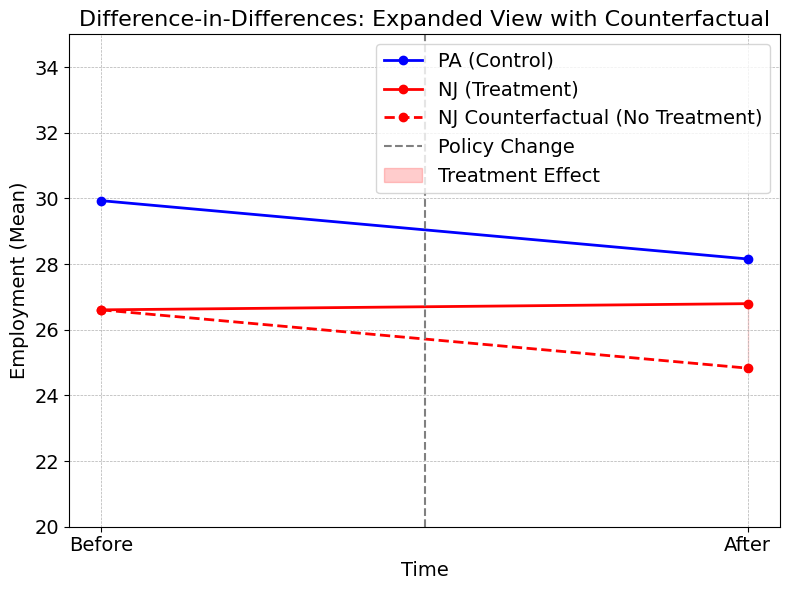

In [56]:
def plot_did_expanded(model, pre_date, post_date, title, post='period', treated='location', post_treated='location_period', y_min=None, y_max=None):
    alpha = model.params['Intercept']
    beta = model.params[post]
    gamma = model.params[treated]
    delta = model.params[post_treated]

    time_labels = [pre_date, post_date]
    pre_time = np.array([0])
    post_time = np.array([1])
    time = np.concatenate((pre_time, post_time))

    control_pre = alpha
    control_post = alpha + beta
    treatment_pre = alpha + gamma
    treatment_post = alpha + beta + gamma + delta
    counterfactual_post = alpha + beta + gamma

    control = np.array([control_pre, control_post])
    treatment = np.array([treatment_pre, treatment_post])
    counterfactual = np.array([treatment_pre, counterfactual_post])

    plt.figure(figsize=(8, 6))
    plt.plot(time, control, 'b-', marker='o', label='PA (Control)', linewidth=2)
    plt.plot(time, treatment, 'r-', marker='o', label='NJ (Treatment)', linewidth=2)
    plt.plot(time, counterfactual, 'r--', marker='o', label='NJ Counterfactual (No Treatment)', linewidth=2)
    plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=1.5, label='Policy Change')

    plt.fill_between(post_time, treatment_post, counterfactual_post, alpha=0.2, color='red', label='Treatment Effect')

    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Employment (Mean)', fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks([0, 1], time_labels, fontsize=14)
    plt.yticks(fontsize=14)
    
    if y_min is not None:
        plt.ylim(y_min, y_max)
        
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

plot_did_expanded(model, 'Before', 'After', 'Difference-in-Differences: Expanded View with Counterfactual', y_min=20, y_max=35)


In [59]:
# Compute means for the example table
mean_table = combined_data.groupby(['location', 'period'])['emp'].mean().unstack()

# Calculate differences for each group and the overall difference-in-differences
nj_diff = mean_table.loc[1, 1] - mean_table.loc[1, 0]  # NJ difference (Post - Pre)
pa_diff = mean_table.loc[0, 1] - mean_table.loc[0, 0]  # PA difference (Post - Pre)
did = nj_diff - pa_diff

# Construct the 2x2 table
result_table = pd.DataFrame({
    'Pre': [mean_table.loc[1, 0], mean_table.loc[0, 0], nj_diff - pa_diff],
    'Post': [mean_table.loc[1, 1], mean_table.loc[0, 1], nj_diff],
    'Difference': [nj_diff, pa_diff, did]
}, index=['New Jersey', 'Pennsylvania', 'Difference'])

# Display the result table
display(result_table)

Pre       Post  Difference
New Jersey    26.606529  26.795533    0.189003
Pennsylvania  29.932836  28.156716   -1.776119
Difference     1.965123   0.189003    1.965123

In [65]:
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

combined_data['location_period'] = combined_data['location'] * combined_data['period']
model = smf.ols('emp ~ location + period + location_period', data=combined_data).fit(cov_type='cluster', cov_kwds={'groups': combined_data['location']})
results_summary = summary_col([model], stars=False, model_names=["Regression"], info_dict={'R-squared': lambda x: f"{x.rsquared:.4f}"})
print(results_summary)



                Regression
--------------------------
Intercept       29.9328   
                (0.0000)  
location        -3.3263   
                (0.0000)  
period          -1.7761   
                (0.0000)  
location_period 1.9651    
                (0.0000)  
R-squared       0.0068    
R-squared Adj.  0.0026    
R-squared       0.0068    
Standard errors in
parentheses.


### Medicaid Expansion